<a href="https://colab.research.google.com/github/Yyzhang2000/AI-Cookbook/blob/main/general_SimCLR_%E2%9C%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [2]:
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

In [3]:
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()
## tqdm for loading bars
from tqdm.notebook import tqdm

<ipython-input-3-85748d32eac8>:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

In [4]:
DATASET_PATH = "../data"
NUM_WORKERS = os.cpu_count()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

BATCH_SIZE = 256
EPOCHS = 5

print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Device: cuda:0
Number of workers: 12


In [5]:
base_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.5,
                                contrast=0.5,
                                saturation=0.5,
                                hue=0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class ContrastiveTransformations:
    def __init__(self, base_transforms, n_views = 2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [6]:
unlabeled_data = STL10(root=DATASET_PATH, split='unlabeled', download=True,
                       transform=ContrastiveTransformations(base_transforms, n_views=2))
train_data_contrast = STL10(root=DATASET_PATH, split='train', download=True,
                            transform=ContrastiveTransformations(base_transforms, n_views=2))

train_loader = data.DataLoader(
    unlabeled_data,
    batch_size = BATCH_SIZE,
    shuffle = True,
    drop_last = False,
    pin_memory=True,
    num_workers=NUM_WORKERS
)

val_loader = data.DataLoader(
    train_data_contrast,
    batch_size = BATCH_SIZE,
    num_workers=NUM_WORKERS,
    drop_last=False,
    pin_memory=True,
)

100%|██████████| 2.64G/2.64G [03:20<00:00, 13.2MB/s]


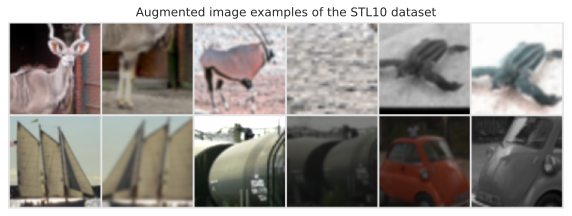

In [7]:
# The entry in the dataset is
# (img1, img2, label)

NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the STL10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [8]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim = 128, temperature=0.5):
        super().__init__()
        assert temperature > 0.0, "Temperature must be positive"

        self.temperature = temperature

        self.convnet = torchvision.models.resnet18(
            num_classes = 4 * hidden_dim
        )

        self.convnet.fc = nn.Sequential(
            self.convnet.fc,
            nn.ReLU(inplace = True),
            nn.Linear(4 * hidden_dim, hidden_dim)
        )


    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, features):
        cos_sim = F.cosine_similarity(
            features[:, None, :], features[None, :, :], dim = -1
        )
        print(cos_sim.shape)

        self_mask  = torch.eye(cos_sim.shape[0], dtype=torch.bool, device= device)

        cos_sim.masked_fill_(self_mask, float('-inf'))

        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims = 0)
        print(pos_mask)

        cos_sim = cos_sim / self.temperature

        nll = - cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim = -1)

        return nll.mean()

In [12]:
def info_nce_loss(model, batch,temperature=0.3,  mode='train'):
    imgs, _ = batch
    # (img1, img2, label)
    # (B, )
    imgs = torch.cat(imgs, dim = 0)
    # print(imgs.shape) # ([512, 3, 96, 96])

    imgs = imgs.to(device)

    features = model(imgs)

    cos_sim = F.cosine_similarity(
        features[:, None, :], features[None, :, :], dim = -1
    )

    self_mask = torch.eye(cos_sim.shape[0], dtype = torch.bool, device = device)
    cos_sim.masked_fill_(self_mask, float('-inf'))

    pos_mask = self_mask.roll(shifts = cos_sim.shape[0] // 2, dims = 0)
    cos_sim = cos_sim / temperature

    nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim = -1)
    nll = nll.mean()

    comb_sim = torch.cat([
        cos_sim[pos_mask][:, None],
        cos_sim.masked_fill(pos_mask, float('-inf'))
    ], dim = -1)
    # print(comb_sim.shape ) # ([256, 257])

    sim_argsort = comb_sim.argsort(dim = -1, descending = True).argmin(dim = -1)
    acc_top1 = (sim_argsort == 0).float().mean()
    acc_top5 = (sim_argsort < 5).float().mean()
    acc_mean_pos = 1 + sim_argsort.float().mean()
    return nll, acc_top1, acc_top5, acc_mean_pos

In [13]:
def train_simclr(model, train_loader, optimizer, scheduler, device, epochs=100):
    model.train()

    losses = []
    top1s = []
    top5s = []
    mean_poses = []
    for epoch in range(epochs):
        total_loss = 0
        total_top1 = 0
        total_top5 = 0
        total_mean_pos = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()
            loss, acc_top1, acc_top5, acc_mean_pos = info_nce_loss(model, batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_top1 += acc_top1.item()
            total_top5 += acc_top5.item()
            total_mean_pos += acc_mean_pos.item()

            losses.append(loss.item())
            top1s.append(acc_top1.item())
            top5s.append(acc_top5.item())
            mean_poses.append(acc_mean_pos.item())

        scheduler.step()

        # 📝 Log epoch metrics
        n_batches = len(train_loader)
        print(f"[Epoch {epoch+1}] Loss: {total_loss/n_batches:.4f} | Top-1 Acc: {total_top1/n_batches:.4f} | Top-5 Acc: {total_top5/n_batches:.4f} | Mean Pos: {total_mean_pos/n_batches:.2f}")

    return losses, top1s, top5s, mean_poses

In [14]:
# 1. Define model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimCLR(hidden_dim=128, temperature=0.3).to(device)

# 2. Define optimizer & scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500, eta_min=1e-3/50)

# 3. Prepare dataloader
# Assume your train_loader gives batches of (augmented_images, labels)
# imgs: a tuple like (img_aug1, img_aug2)

# 4. Train
losses, top1s, top5s, mean_poses = train_simclr(model, train_loader, optimizer, scheduler, device, epochs=EPOCHS)

Epoch 1/5:   0%|          | 0/391 [00:00<?, ?it/s]

[Epoch 1] Loss: 5.2120 | Top-1 Acc: 0.0672 | Top-5 Acc: 0.1861 | Mean Pos: 75.64


Epoch 2/5:   0%|          | 0/391 [00:00<?, ?it/s]

[Epoch 2] Loss: 4.6447 | Top-1 Acc: 0.2076 | Top-5 Acc: 0.4179 | Mean Pos: 36.71


Epoch 3/5:   0%|          | 0/391 [00:00<?, ?it/s]

[Epoch 3] Loss: 4.4458 | Top-1 Acc: 0.3018 | Top-5 Acc: 0.5325 | Mean Pos: 25.72


Epoch 4/5:   0%|          | 0/391 [00:00<?, ?it/s]

[Epoch 4] Loss: 4.3351 | Top-1 Acc: 0.3711 | Top-5 Acc: 0.5977 | Mean Pos: 20.54


Epoch 5/5:   0%|          | 0/391 [00:00<?, ?it/s]

[Epoch 5] Loss: 4.2663 | Top-1 Acc: 0.4171 | Top-5 Acc: 0.6418 | Mean Pos: 17.70


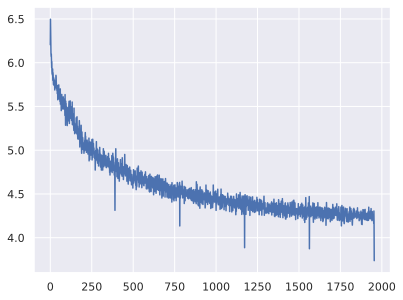

In [15]:
plt.plot(losses)

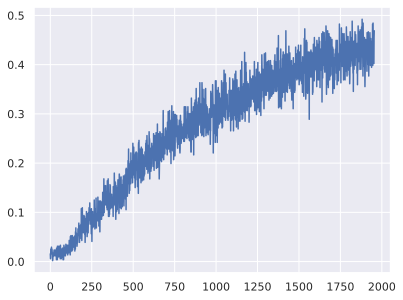

In [16]:
plt.plot(top1s)

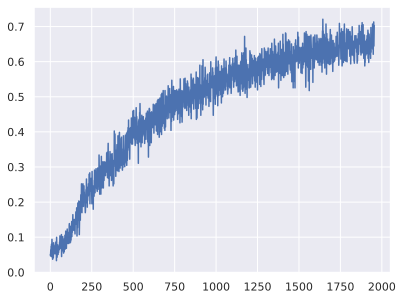

In [17]:
plt.plot(top5s)

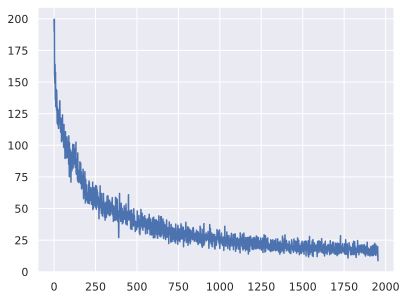

In [18]:
plt.plot(mean_poses)